<a href="https://colab.research.google.com/github/i-am-pad/DSCI591/blob/master/project/preprocessing/sorel20m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

The full Sorel-20M dataset is stored in the dsci591_g4_sorel20m bucket on us-east1 using the "Standard" storage class. The file structure under this bucket is a carbon copy made using Google's Storage Transfer Service, copying the origin dataset from its public S3 bucket to the dsci591_g4_sorel20m bucket on GCS. The file structure is provided by the authors here. The following just authenticates to facilitate access to this bucket and then copies meta.db to be loaded.

# Imports

In [126]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3
import tensorflow as tf
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zlib

# Meta.db Exploration

## Loading

### Colab

The following authenticates with Google and loads meta.db from the GCS bucket it's stored in.

In [8]:
# disabling this while we figure out what we're going to do with the sorel-20m dataset's size
# and the need for a larger VM to even just load this database's content
USE_COLAB = False

if USE_COLAB:
    from google.colab import auth

    auth.authenticate_user()

    #project_id = 'fluid-amulet-337018'
    bucket_name = 'dsci591_g4_sorel20m'
    meta_db_prefix = os.path.join('09-DEC-2020', 'processed-data')
    meta_db_name = 'meta.db'
    meta_db_path_gs = os.path.join(bucket_name, meta_db_prefix, meta_db_name)
    meta_db_path_local = os.path.join('/tmp', meta_db_name)

    if not tf.io.gfile.exists('/tmp/meta.db'):
        tf.io.gfile.copy(f'gs://{bucket_name}/{meta_db_path_gs}', meta_db_path_local)

        conn = sqlite3.connect('/tmp/meta.db')

### Local

The following loads meta.db from the local filesystem.

In [7]:
USE_LOCAL = True and not USE_COLAB

if USE_LOCAL:
    meta_db_path = r'd:/data/sorel20m/meta.db'
    conn = sqlite3.connect(meta_db_path)

### Exploration

In [9]:
df_meta = pd.read_sql('select * from meta', con=conn)
df_meta.head()

,sha256,is_malware,rl_fs_t,rl_ls_const_positives,adware,flooder,ransomware,dropper,spyware,packed,crypto_miner,file_infector,installer,worm,downloader
0,de66443f0fc555753e64a34c99d9667abcf59dacca9198...,0,1.483229e+09,1,0,0,0,0,0,0,0,0,0,0,0
1,047316c8118e6e4d088c4aaebab34a031e62ecc42ecefc...,1,1.483229e+09,5,0,0,0,0,0,0,0,0,0,0,0
2,d6953e9740b0b396650bfab9983c557a443bcdbad2d67a...,0,1.483229e+09,1,0,0,0,0,0,0,0,0,0,0,0
3,7e4ee821a55bfe16596f2e99d4163fa77d455a4961407b...,0,1.483229e+09,1,0,0,0,0,0,0,0,0,0,0,0
4,997990bb784a9689e4293d788964c6a76ea7a1ff369a61...,1,1.483229e+09,6,0,0,0,0,0,0,0,0,0,0,0


#### Sample Imbalance

While the overall set of binaries is pretty well balanced between overall malware vs benign, the individual types of malware are quite imbalanced. That means if the group were to try to train a classifier for specific types of malware on this dataset, special attention to F1 for class-specific scores would need to be taken. Or we could just use a strategy of balanced subsampling for training and test data from the overall dataset. Even if we do binary classification, we probably still want to make sure that the subtypes are balanced in whatever sample we use, otherwise the classifier may not have enough data to learn how to detect malware of the underrepresented types.

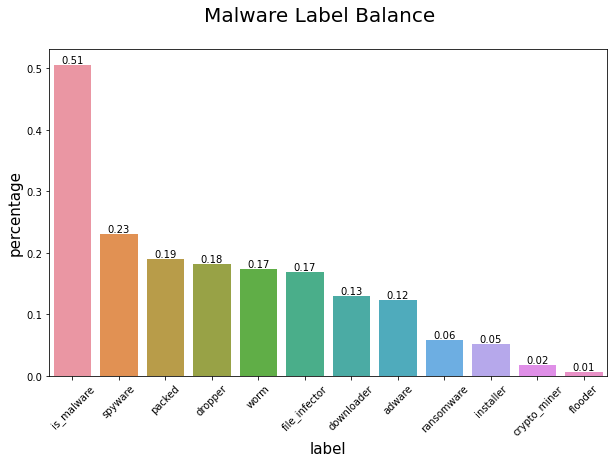

In [66]:
target_fields = [
    c
    for c in df_meta.columns
    if c not in {'sha256', 'rl_fs_t', 'rl_ls_const_positives'}
]
data = (df_meta
        .loc[:, target_fields]
        # spyware seems to be more diverse than 0 or 1
        .astype(np.bool8)
        .sum() / df_meta.shape[0]
        ).sort_values(ascending=False)
data

fig, ax = plt.subplots(1, figsize=(10,6))

_ = sns.barplot(data=pd.DataFrame(data).reset_index().rename(columns={0: 'percentage', 'index': 'label'}),
                x='label',
                y='percentage',
                ax=ax,
                )

_ = fig.suptitle('Malware Label Balance', fontsize=20)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
_ = ax.set_xlabel(ax.get_xlabel(), fontsize=15)
_ = ax.set_ylabel(ax.get_ylabel(), fontsize=15)

for c in ax.containers:
    _ = ax.bar_label(c, fmt='%.2f')

## Subsampling

The dataset's binaries total 8TB in size, which is prohibitively costly to both store and preprocess in the Google Cloud environment. The files are also all in the same directory, only identifiable by a generic sha256 hash of their contents, which is what is used to identify them in meta.db for additional generic details about them.

So with the constraint of overall dataset size with respect to Google Cloud costs and also taking into consideration the imbalance in the malware types in the dataset, a strategy for subsampling a balanced representation of malware by type vs benign samples is required. This will be used to pare down the overall dataset by selecting target files to use from the database as a percentage of the count of files. While the files' sizes vary, the assumption is that if 1% of the 20,000,000 files that constitute 8TB are sampled, we'll be somewhere close to a more tractable total of \~80GB of binaries over \~200,000 files to work with.

The way the following code will be used is:

1. find a subsample of names that meets the target portion of 1%,
2. select half of that in total number of benign samples' sha256 names,
3. and concatenate the sha256 names for the number of malware files for the other half, evenly portioned by the number of malware types,
4. create copies of these in a new directory on the GCS bucket,
5. verify the size and integrity of the copied subsample,
6. and then delete the original, complete 8TB set of binaries.

In [73]:
# needs doing, but will be once-and-done when it's executed
DO_SUBSAMPLE = False

if DO_SUBSAMPLE:
    total_files = df_meta.shape[0]
    sample_portion = 0.01
    num_benign_samples = total_files * sample_portion
    # removing 1 because is_malware isn't a malware type
    num_malware_samples_per_type = total_files * sample_portion * (len(target_fields) - 1)

    # TODO - will do this _after_ what's needed for 4/29's meeting with the professor is created

# Image Creation

An approach to converting binaries to same-dimension grayscale images using a sample of 25 binaries from the dataset.

## Colab

In [72]:
if USE_COLAB:
    pass # TODO, once we can actually work with this dataset on colab

## Local

In [158]:
if USE_LOCAL:
    binaries_dir = r'd:/data/sorel20m/binaries'
    save_dir = r'd:/data/sorel20m/images'
    # height, width, channels (e.g. 1 for grayscale, 3 for rgb, 4 for rgba)
    # 512x512x1 := 256 KiB
    target_shape = (1024, 1024, 1)
    total_bytes_allowed = target_shape[0] * target_shape[1] * target_shape[2]
    # truncates a file's bytes during conversion if the total number of bytes
    # exceeds total_bytes_allowed and do_truncate is True. otherwise, files exceeding
    # total_bytes_allowed are just skipped.
    do_truncate = True
    
    # this is no good for these binaries. it assumes you're augmenting what are already
    # images. is that what the pdf dataset already is? what about when these are just
    # a typical uint8 bag of bytes?
    # idg = ImageDataGenerator(fill_mode = 'constant', cval = 0)
    #for image, label in idg.flow_from_directory(binaries_location,
    #                                            target_size=(512, 512),
    #                                            color_mode='grayscale',
    #                                            save_to_dir=r'd:/data/sorel20m/images',
    #                                            batch_size=10000000,
    #                                            ):
    
    image_paths = []
    bytes_truncated = []
    for type in os.listdir(binaries_dir):
        # "type" is insignificant for the moment, since the local samples are just cut up
        # across directories as an example for the way they'll need to be once
        # keras ImageDataGenerator can use the converted images. so this is just a placeholder
        # approach until the types are actually truly represented by the directory structure
        # beyond this example code.
        type_dir = os.path.join(binaries_dir, type)
        type_save_dir = os.path.join(save_dir, type)
        if not os.path.exists(type_save_dir):
            os.makedirs(type_save_dir)
        
        for file in os.listdir(type_dir):
            load_path = os.path.join(type_dir, file)
            data = np.fromfile(load_path, dtype=np.uint8)
            if not do_truncate and data.shape[0] > total_bytes_allowed:
                continue
            
            to_write = np.zeros(shape=(total_bytes_allowed,))
            # will truncate if > total_bytes_allowed; size bound is set by target_shape
            num_bytes = min(data.shape[0], total_bytes_allowed)
            if (truncated := max(0, data.shape[0] - total_bytes_allowed)):
                #print(load_path, data.shape[0], truncated)
                bytes_truncated.append(truncated)
            to_write[:num_bytes] = data[:num_bytes]
            
            save_path = os.path.join(type_save_dir, file)
            # n.b.: cv2.imwrite could be used here, but that actually truncates trailing zero padding!
            with open(save_path, 'wb') as fout:
                np.save(fout, to_write, allow_pickle=False, fix_imports=False)
            image_paths.append(save_path)
            #plt.show(plt.imshow(to_write.reshape(target_shape), cmap='gray', vmin=0, vmax=255))

    print(f'average bytes lost through truncation over {len(image_paths)} files: {sum(bytes_truncated) / len(bytes_truncated)}')
    print(f'min-max bytes truncated: {min(bytes_truncated)}-{max(bytes_truncated)}')

average bytes lost through truncation over 18 files: 2691892.8
min-max bytes truncated: 101830-9971961


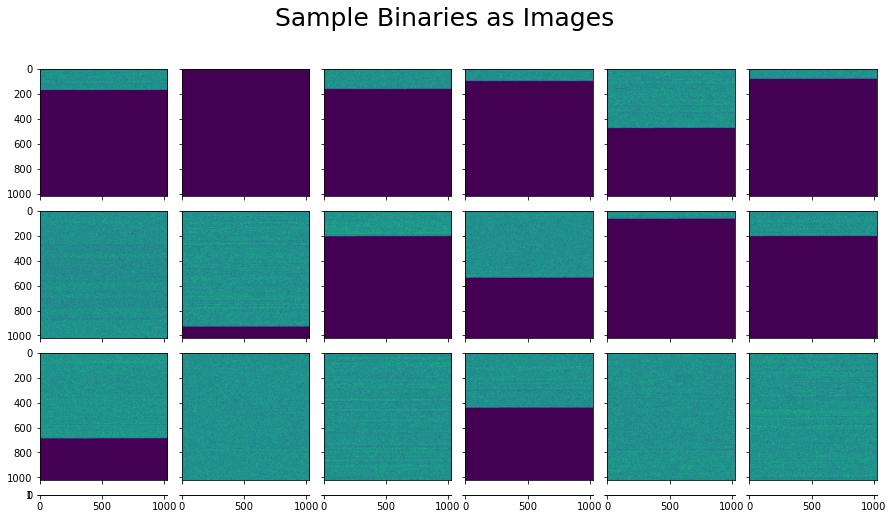

In [176]:
images = []
for ip in image_paths:
    images.append(np.load(ip).reshape(target_shape))

# https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html
fig = plt.figure(figsize=(15, 8))
cols = 6
grid = ImageGrid(fig,
                 111,
                 nrows_ncols=(len(images) // cols + 1, cols),
                 axes_pad = 0.2
                 )

for ax, image in zip(grid, images):
    ax.imshow(image)

_ = plt.suptitle(f'Sample Binaries as Images', fontsize=25)

plt.show()